# Hands on Computer Vision: Build Production-Grade Models in an Hour

This notebook demonstrates practical implementations of core computer vision tasks using pre-trained deep learning models. We'll explore how to perform semantic segmentation.

**Semantic Segmentation**: Pixel-level identification of objects and regions in images

Each section includes:
- Loading and preprocessing images
- Using pre-trained models for inference
- Visualizing and interpreting results

Prerequisites:
- Basic Python knowledge
- Understanding of NumPy and PyTorch
- Familiarity with image processing concepts

All required dependencies are listed in the requirements.txt file of the repository.

# Setup and Imports

Before diving into computer vision tasks, let's set up our environment to access project files and utilities. This step ensures we can easily load images and use helper functions from our project structure.

In [1]:
# all imports
import sys
import torch
import random
import numpy as np
import glob as glob
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt


In [2]:
# Set up Python path to access our utility modules
# Since this notebook is in the 'notebooks' directory, we need to add the parent (repo root) 
# to the Python path to be able to import from the 'src' directory

# Get current notebook's path and add repo root to Python path
notebook_path = Path().resolve()
repo_root = notebook_path.parent.parent
sys.path.append(str(repo_root))

# Import pre-defined paths to our image directories
# These paths are defined in src/paths.py for consistent use across the project
from src.paths import CLASSIFICATION_IMAGES, DETECTION_IMAGES, SEGMENTATION_IMAGES
# path where to save the downloaded models
from src.paths import MODELS_DIR
# Now we can use these paths to access our images for each task:
# CLASSIFICATION_IMAGES - for image classification
# DETECTION_IMAGES - for object detection
# SEGMENTATION_IMAGES - for semantic segmentation

In [3]:
# Check if CUDA (GPU) is available
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Example Image Segmentation Task


In [4]:
# Utility function to load files for any given task
def get_files_path_for_task(task):
    if task == "image_classification":
        dir_path = CLASSIFICATION_IMAGES
    elif task == "object_detection":
        dir_path = DETECTION_IMAGES
    elif task == "semantic_segmentation":
        dir_path = SEGMENTATION_IMAGES
    else:
        raise ValueError(f"Unknown task to load files: {task}")
    files = []
    for ext in ['.jpg', '.jpeg', '.png', '.webp']:
        files.extend(list(dir_path.glob(f'*{ext}')))
    
    # Sort files for consistent ordering
    files.sort()
    
    print("Found image files for task {task}: ")
    for img_path in files:
        print(f"- {img_path.name}")
    return files


In [5]:
# get file paths for image classification task
semantic_segmentation_files = get_files_path_for_task(task="semantic_segmentation")

Found image files for task {task}: 
- beatles.png


### Utility Functions for prediction and visualization

In [6]:
def predict_and_plot_pytorch(image_path, model, preprocess, class_labels, title="Model Predictions"):
    """
    Make predictions using PyTorch models and visualize results
    """
    # Load image
    image = Image.open(image_path)
    
    # Get predictions
    with torch.no_grad():
        input_tensor = preprocess(image).unsqueeze(0).to(device)
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
    
    # Get top 5 predictions
    probs, catids = torch.topk(probabilities, 5, largest=True)
    probs = probs.cpu().numpy()[::-1]
    catids = catids.cpu().numpy()[::-1]
    
    # Create label dictionary
    labels_dict = {i: label for i, label in enumerate(class_labels)}
    
    # Plot results
    plot_predictions(image, probs, catids, labels_dict, title)

def plot_predictions(image, probs, catids, labels_dict, title):
    """
    Helper function to plot the image and predictions
    """
    plt.figure(figsize=(10, 4))
    
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis('off')
    
    # Top 5 predictions
    plt.subplot(1, 2, 2)
    bars = plt.barh(np.arange(5), probs)
    plt.yticks(np.arange(5), [labels_dict[idx] for idx in catids])
    plt.xlabel('Probability')
    plt.title(title)
    
    # Add probability values on bars
    for bar in bars:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
                f'{bar.get_width():.3f}', 
                va='center', ha='left', fontsize=9)
    
    plt.xlim(0, max(probs) * 1.1)
    plt.tight_layout()

# utility function to plot the labels in a grid
def plot_random_labels(labels_to_plot, title):
   random.seed(42)
   class_names = random.sample(labels_to_plot, 25)
    
   # Light green pastel color
   pastel_color = '#BAFFC9'
   
   fig, ax = plt.subplots(5, 5, figsize=(10, 2.5))
   fig.suptitle(title, fontsize=12, y=0.95)
   
   for i, (name, subplot) in enumerate(zip(class_names, ax.flat)):
       # Create a colored background rectangle
       subplot.add_patch(plt.Rectangle((0, 0), 1, 1, facecolor=pastel_color))
       subplot.text(0.5, 0.5, name, ha='center', va='center', fontsize=8)
       subplot.set_xticks([])
       subplot.set_yticks([])
   
   plt.tight_layout()

def visualize_image(image_path):
    plt.figure(figsize=(8,4))
    classification_image = plt.imread(image_path)
    plt.imshow(classification_image)
    plt.axis("off")

# Image Segmentation

This is an advanced use case where the model is applied to segment objects in an image, rather than just detecting them. Unlike traditional object detection, segmentation involves classifying each pixel in an image, allowing precise boundaries for objects like cars, people, or buildings.

## Object Detection vs Image Segmentation

The key differences lie in their outputs and requirements:

### Output Format
- **Object Detection**: Produces bounding boxes around objects with class labels
- **Image Segmentation**: Generates pixel-wise masks, classifying each pixel in the image

### Training Requirements
- **Object Detection**: Needs annotations specifying object locations
- **Image Segmentation**: Requires detailed pixel-level annotations

### Computational Complexity
- **Object Detection**: Uses simpler loss functions (bounding box and classification loss)
- **Image Segmentation**: More resource-intensive, using complex loss functions (e.g., Dice loss) for precise boundaries

In [8]:
segmentation_fpaths = get_files_path_for_task(task="semantic_segmentation")

Found image files for task {task}: 
- beatles.png


## Visualize The Image for Segmentation

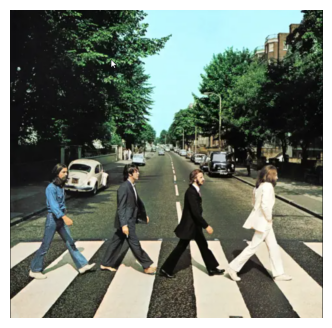

In [9]:
img_to_segment = segmentation_fpaths[0]

visualize_image(img_to_segment)

## Loading Segmentation Model

In [11]:
from ultralytics import YOLO

model_path = MODELS_DIR / "yolo11n-seg.pt"
yolo11_segmentation_model = YOLO(model_path)

## Segmenting an Image With YOLO 

In [12]:
# setting threshold !!! IMPORTANT HYPERPARAMETER !!!
conf = 0.7

# Make prediction
segmentation_results = yolo11_segmentation_model.predict(img_to_segment, conf=conf)


image 1/1 /Users/hansimgluck/Desktop/Computer_vision/data/visuals/semantic_segmentation/beatles.png: 640x640 4 persons, 1 car, 314.8ms
Speed: 18.1ms preprocess, 314.8ms inference, 20.6ms postprocess per image at shape (1, 3, 640, 640)


## Count Segmented Objects

In [13]:
# Get first result from segmentation
segmentation_result = segmentation_results[0]

# Count segmented objects by class
segment_counts = {}
for segment, box in zip(segmentation_result.masks, segmentation_result.boxes):
    class_id = int(box.cls[0])  # Get class from boxes
    class_name = segmentation_result.names[class_id]  # Use names from segmentation result
    segment_counts[class_name] = segment_counts.get(class_name, 0) + 1

# Print summary
print("Segmented objects:")
print("-" * 30)
print(f"Total objects segmented: {len(segmentation_result.masks)}")
print("-" * 30)
for class_name, count in segment_counts.items():
    print(f"{class_name}: {count}")

Segmented objects:
------------------------------
Total objects segmented: 5
------------------------------
person: 4
car: 1


Text(0.5, 1.0, 'Segmentation Results')

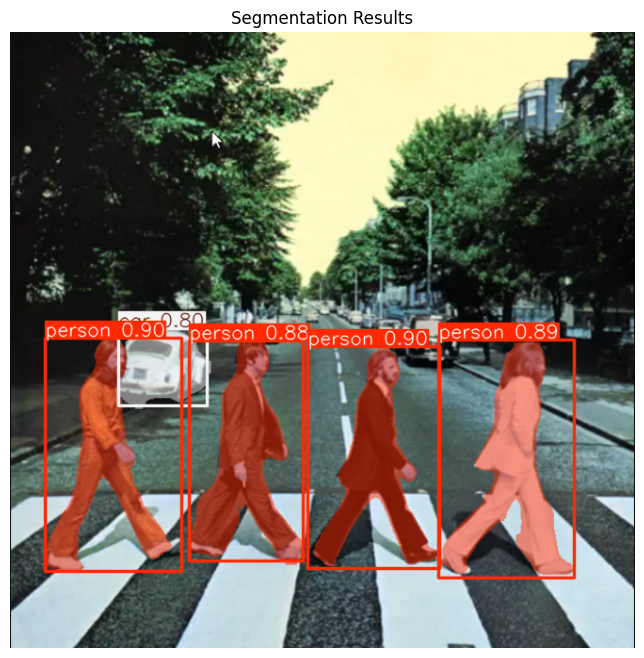

In [14]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.imshow(segmentation_result.plot())  # YOLO's built-in plotting method
plt.axis('off')
plt.title("Segmentation Results")

Voila ! You did it!
In conclusion, the versatility of leveraging pre-trained models like YOLOv11 for image segmentation showcase state-of-the-art performance, enabling efficient and accurate solutions for diverse computer vision tasks with minimal effort.